In [1]:
import sys
sys.path.append('../sample/')
from ann import NeuralNetwork

sys.path.append('../../') # put `little_mcmc/` in `../../`.
import little_mcmc.sample.mcmc as mc


import numpy as np
from random import gauss, random
from time import time
import matplotlib.pyplot as plt

Typing Hint:

In [2]:
from typing import List, Tuple, Mapping

Array = np.array(List[float])
Value = float

### Set global variables:

In [3]:
# Ann
net_size = [5, 1]
input_size = 1

# effective_dim = num_of_connections
effective_dim = np.prod(net_size) * (input_size * net_size[0])
print('effective_dim: ', effective_dim)

step_length = 0.5

chain_num = 1 #* effective_dim
tolerence = 0.00
max_break_counter = 100 * effective_dim

effective_dim:  25


### Set error-function as, e.g.,

In [4]:
def error_function(outputs: Array, targets: Array) -> float:
    
    assert len(outputs) == len(targets)
    
    return 0.5 * np.sum(np.square(outputs - targets)) / len(outputs)

## Aim: fit `[0.5 * sin(x) for x in np.linspace(-7, 7, 20)]`.

### Preparing for MCMC

In [5]:
def random_move(net: NeuralNetwork, step_length=step_length) -> NeuralNetwork:
    result_net = net.copy()
    
    for layer in result_net.layers:
        for perceptron in layer:
            perceptron.weights = (  perceptron.weights
                                  + np.array([ gauss(0, 1) * step_length
                                               for _ in range(len(perceptron.weights))])
                                 )
    
    return result_net

In [7]:
init_net = NeuralNetwork(net_size, input_size)
print(init_net.weights)

print()
new_net = random_move(init_net, step_length=1)
print(new_net.weights)

[[[-0.012238525726617863, 0.014701860668600047], [-0.0036235942737441323, -0.0017714734742859672], [0.030070041071148815, -0.010644024546527985], [-0.04520577481838545, 0.0030548470587429613], [-0.004087761326031322, -0.00542010800786151]], [[0.03008669241255056, 0.026360643156661936, -0.022225835679516515, -0.009217143713338746, -0.028103291430212098, -0.03561484830815727]]]

[[[-0.012238525726617863, 0.014701860668600047], [-0.0036235942737441323, -0.0017714734742859672], [0.030070041071148815, -0.010644024546527985], [-0.04520577481838545, 0.0030548470587429613], [-0.004087761326031322, -0.00542010800786151]], [[0.03008669241255056, 0.026360643156661936, -0.022225835679516515, -0.009217143713338746, -0.028103291430212098, -0.03561484830815727]]]


Function to maximize:

In [6]:
# Input
x = np.linspace(-7, 7, 20)

# Target
y = np.sin(x) * 0.5


def f(net: NeuralNetwork, inputs=x, targets=y) -> Value:
        
    outputs = np.array([net.output([__])[0] for __ in inputs])
    erf = error_function(outputs, targets)
    
    return -1 * np.log(erf)

### Do MCMC

In [7]:
# Do mcmc
chain_list = []

t_begin = time()

for step in range(chain_num):
    init_net = NeuralNetwork(net_size, input_size)

    net_chain = mc.single_chain_mcmc(
                     f, random_move, init_net,
                     tolerence=tolerence,
                     max_break_counter=max_break_counter,
                     iterations = 10 ** 10
                     )
    chain_list.append(net_chain)

bc = mc.best_chain(chain_list)
best_net = bc[-1][0]
ef_value = bc[-1][1]

t_end = time()
print('time spent by fitting: ', t_end - t_begin)

time spent by fitting:  11.111337900161743


### Show Result

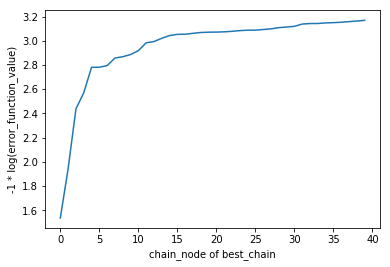

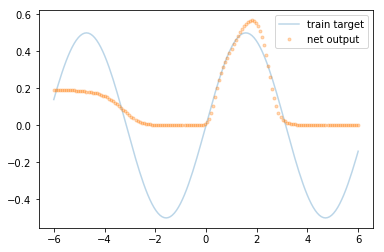

In [8]:
error_function_values = [__[1] for __ in bc]
plt.plot([i for i in range(len(error_function_values))],
         error_function_values)
plt.xlabel('chain_node of best_chain')
plt.ylabel('-1 * log(error_function_value)')
plt.show()


plot_x = np.linspace(-6.0,6.0,150)
plot_y_ann = [best_net.output([__]) for __ in plot_x]
plot_y_target = np.sin(plot_x) * 0.5

plt.plot(plot_x, plot_y_target, '-',
         plot_x, plot_y_ann, '.', alpha = 0.3
        )
plt.legend(['train target', 'net output'])
plt.show()

**Far from good.**

Further exame

In [9]:
test_net = random_move(best_net, 0.01)

print('test: ', f(test_net))
print('best: ', f(best_net))

print('test of relative gain: ', mc.relative_gain(f(best_net), f(test_net)))

test:  3.16828637901
best:  3.16922518509
test of relative gain:  -0.000148134811364


### Print out Fitted Weights

In [10]:
for i in range(len(best_net.layers[0])):
    print(best_net.layers[0][i].weights)

print()

for i in range(len(best_net.layers[1])):
    print(best_net.layers[1][i].weights)

[ 1.97831267  4.63376738]
[-2.87947848  8.27139353]
[-6.47137095 -0.66589939]
[ 5.74124984 -0.69394969]
[-1.94481334  2.3541758 ]

[-6.72909349  7.55430645 -3.6069043   3.24701081 -2.51953039 -2.8617631 ]
